In [1]:
import torch
import torch.nn as nn
import random
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
import time
import pylab as pl
from IPython import display

In [2]:
class MaxAndSkipEnv(gym.Wrapper):
    """
        Each action of the agent is repeated over skip frames
        return only every `skip`-th frame
    """
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

In [3]:
class MarioRescale84x84(gym.ObservationWrapper):
    """
    Downsamples/Rescales each frame to size 84x84 with greyscale
    """
    def __init__(self, env=None):
        super(MarioRescale84x84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return MarioRescale84x84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution." 
        # image normalization on RBG
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

In [4]:
class ImageToPyTorch(gym.ObservationWrapper):
    """
    Each frame is converted to PyTorch tensors
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

In [5]:
class BufferWrapper(gym.ObservationWrapper):
    """
    Only every k-th frame is collected by the buffer
    """
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

In [6]:
class PixelNormalization(gym.ObservationWrapper):
    """
    Normalize pixel values in frame --> 0 to 1
    """
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

In [16]:
def create_mario_env(env):
    env = MaxAndSkipEnv(env)
    env = MarioRescale84x84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = PixelNormalization(env)
    return JoypadSpace(env, SIMPLE_MOVEMENT)
  

In [8]:
class DQNSolver(nn.Module):
    """
    Convolutional Neural Net with 3 conv layers and two linear layers
    """
    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [9]:
class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dqn, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dqn = double_dqn
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Double DQN network
        if self.double_dqn:  
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("DQN1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("DQN2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
            self.step = 0
        # DQN network
        else:  
            self.dqn = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("DQN.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        """Store the experiences in a buffer to use later"""
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
    
    def batch_experiences(self):
        """Randomly sample 'batch size' experiences"""
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]      
        return STATE, ACTION, REWARD, STATE2, DONE
    
    def act(self, state):
        """Epsilon-greedy action"""
        if self.double_dqn:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dqn:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
    
    def copy_model(self):
        """Copy local net weights into target net for DDQN network"""
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        """Use the double Q-update or Q-update equations to update the network weights"""
        if self.double_dqn and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return
    
        # Sample a batch of experiences
        STATE, ACTION, REWARD, STATE2, DONE = self.batch_experiences()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dqn:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * self.target_net(STATE2).max(1).values.unsqueeze(1)),  1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * self.dqn(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)
  

In [10]:
def show_state(env, ep=0, info=""):
    """While testing show the mario playing environment"""
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    

In [11]:
def run(training_mode, pretrained, double_dqn, world, level, num_episodes=1000, exploration_max=1):
    game_level = 'SuperMarioBros-' + str(world) + '-' + str(level) + '-v0'
    env = gym_super_mario_bros.make(game_level)
    env = create_mario_env(env)  # Wraps the environment so that frames are grayscale 
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.2,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dqn=double_dqn,
                     pretrained=pretrained)
    
    # Restart the enviroment for each episode
    num_episodes = num_episodes
    env.reset()
    
    total_rewards = []
    if training_mode and pretrained:
        with open("total_rewards.pkl", 'rb') as f:
            total_rewards = pickle.load(f)
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num)
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)
        
        if ep_num != 0 and ep_num % 100 == 0:
            print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))
        num_episodes += 1  

    print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))
    
    # Save the trained memory so that we can continue from where we stop using 'pretrained' = True
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dqn:
            torch.save(agent.local_net.state_dict(), "DQN1.pt")
            torch.save(agent.target_net.state_dict(), "DQN2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "DQN.pt")  
        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")
    
    env.close()
 

In [12]:
# For training
def train(world, level, num_ep):
    run(training_mode=True, pretrained=False, double_dqn=True, world=world, level=level,num_episodes=num_ep, exploration_max = 1)

In [13]:
# For Testing
def test(world, level, ep_num):
    run(training_mode=False, pretrained=True, double_dqn=True, world=world, level=level, num_episodes=ep_num, exploration_max = 0.05)

In [14]:
train_world = 1
train_level = 3
training_ep = 50000

#train(train_world, train_level, training_ep)

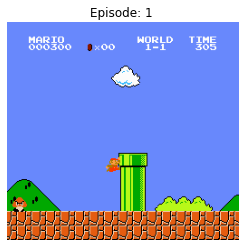

In [ ]:
world = 1
level = 1
num_of_tries = 21
test(world, level, num_of_tries)